### Datasets
    - gdsc --> gg
    - ctrp --> cc
### Models
    - lgb
    - nn0
    - nn1
    
### Runs:
`../lc.out.summit.July2020/exp1_scores`<br>
    - summit run (completed runs for very large sizes: 600K>)<br>
    - haven't calculated MCC<br>
    
`../lc.out.nci60.split0/`

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from load_modules import *
%matplotlib inline
fpath = Path(os.getcwd())
print('Current path:', fpath)

outpath = fpath/'figs'
os.makedirs(outpath, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current path: /vol/ml/apartin/projects/covid-19/docking-learning-curves/nbs


## Path to data

In [6]:
fname = 'all_scores.csv'
dpath = Path('../lc.out.linear')

dirs = glob(str(dpath/'*'))
print(dirs)

['../lc.out.linear/lc.3CLPro.flatten', '../lc.out.linear/lc.3CLPro.random']


In [7]:
src = '3CLPro'
rnd_path = Path(dpath, f'lc.3CLPro.random', fname)
flt_path = Path(dpath, f'lc.3CLPro.flatten', fname)
lgb_path = None

## Load data

In [8]:
def get_data(path, tr_set='te'):
    if path is None:
        return None
    else:
        return load_data(path, tr_set=tr_set);

rr = get_data(rnd_path, tr_set='te');
ff = get_data(flt_path, tr_set='te');

In [9]:
print(rr.shape)
print(ff.shape)

(72, 5)
(72, 5)


In [12]:
df = rr
# df = ff
df[df.metric=='mean_absolute_error'].sort_values('tr_size')

,run,tr_size,set,metric,score
6,run0,50000,te,mean_absolute_error,0.524370
13,run0,157142,te,mean_absolute_error,0.498446
24,run0,264285,te,mean_absolute_error,0.487989
29,run0,371428,te,mean_absolute_error,0.480402
44,run0,478570,te,mean_absolute_error,0.477808
45,run0,600000,te,mean_absolute_error,0.465420
55,run0,700000,te,mean_absolute_error,0.468614
69,run0,750000,te,mean_absolute_error,0.467236


In [13]:
def print_count(aa):
    # aa = nn0_rnd
    aa['one'] = 1
    aa = aa[(aa['set']=='te') & (aa['metric']=='mean_absolute_error')]
    display(aa.groupby(['tr_size']).agg({'one': 'sum'}).sort_values('tr_size').reset_index())
    
print_count(aa=rr)
print_count(aa=ff)

,tr_size,one
0,50000,1
1,157142,1
2,264285,1
3,371428,1
4,478570,1
5,600000,1
6,700000,1
7,750000,1


,tr_size,one
0,50000,1
1,157142,1
2,264285,1
3,371428,1
4,478570,1
5,585713,1
6,692856,1
7,799999,1


## Raw plots

In [14]:
# Global plotting params
# -------------------------------
met = 'mean_absolute_error'
# met = 'mcc'
t_set = 'te'
# xtick_scale = 'log2'
# ytick_scale = 'log2'
xtick_scale = 'linear'
ytick_scale = 'linear'

kwargs = {'metric_name': met,
          'tr_set': t_set,
          'xtick_scale': xtick_scale,
          'ytick_scale': ytick_scale,
          'plot_median': True}

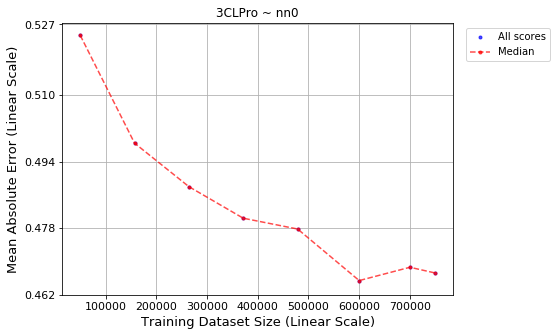

In [15]:
# Plot random
# -------------------------------
if rr is not None:
    kwargs.update({'title': f'{src} ~ random'})
    ax = lc_plots.plot_lc_single_metric(rr, **kwargs);

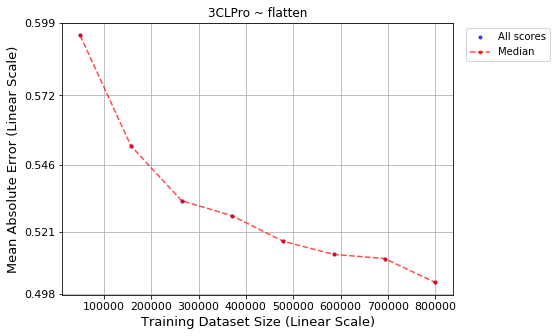

In [16]:
# Plot random
# -------------------------------
if ff is not None:
    kwargs.update({'title': f'{src} ~ flatten'})
    ax = lc_plots.plot_lc_single_metric(ff, **kwargs);

In [183]:
# Plot
# -------------------------------
if lgb is not None:
    kwargs.update({'title': f'{src} ~ lgb'})
    ax = lc_plots.plot_lc_single_metric(lgb, **kwargs);

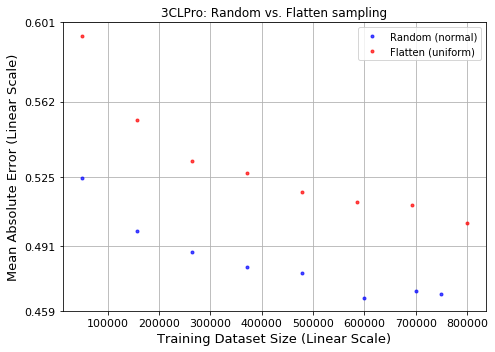

In [20]:
# Plot
# -------------------------------
ax = None
kwargs = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale}

if rr is not None:
    rr = rr[rr.metric==met].reset_index(drop=True)
    ax = lc_plots.plot_lc(x=rr['tr_size'].values, y=rr['score'].values, color='b', label='Random (normal)', **kwargs, ax=ax);

if ff is not None:
    ff = ff.copy()
    ff = ff[ff.metric==met].reset_index(drop=True)
    ax = lc_plots.plot_lc(x=ff['tr_size'].values, y=ff['score'].values, color='r', label='Flatten (uniform)', **kwargs, ax=ax);
    
ax.legend(loc='best')
ax.set_title('3CLPro: Random vs. Flatten sampling')
plt.tight_layout()
plt.savefig(outpath/('3CLPro_random_vs_flatten.png'), dpi=100)

## Fitting

In [185]:
# # Choose the dataset
# df = nn0.copy(); model = 'nn0'
# # df = nn1.copy(); model = 'nn1'
# # df = lgb.copy(); model = 'LGBM'

# # ----------------
# # Prepare the data
# # ----------------
# df = df[ df['metric']==met ].reset_index(drop=True)
# print('Raw dataset of scores', df.shape)

# # Agg scores
# df['y'] = df['score']
# df = df[df['metric']==met].groupby('tr_size').agg({'y': 'median'}).reset_index()
# print('Agg with median', df.shape)

# # Split dfit and dext
# x_fit_mn = 1000
# x_fit_mx = None

# dfit = subset_data(df, col='tr_size', x_mn=x_fit_mn, x_mx=x_fit_mx)
# dfit = add_weight_col(dfit)

# print('dfit.shape:', dfit.shape)
# print('Train size (dfit):', dfit['tr_size'].unique())

In [186]:
nn0 = nn0_rnd
nn1 = nn1_rnd

# nn0 = nn0_flt
# nn1 = nn1_flt

In [187]:
def fit_data(df, x_fit_mn=0, x_fit_mx=None):
    if df is None:
        return None
    
    df = df[ df['metric']==met ].reset_index(drop=True)
    df['y'] = df['score']
    df = df[df['metric']==met].groupby('tr_size').agg({'y': 'median'}).reset_index()
    
    dfit = subset_data(df, col='tr_size', x_mn=x_fit_mn, x_mx=x_fit_mx)
    dfit = add_weight_col(dfit)
    return dfit

In [188]:
# Split dfit and dext
x_fit_mn = 1000
x_fit_mx = None

dfit_nn0 = fit_data(nn0, x_fit_mn=x_fit_mn, x_fit_mx=x_fit_mx)
dfit_nn1 = fit_data(nn1, x_fit_mn=x_fit_mn, x_fit_mx=x_fit_mx)
dfit_lgb = fit_data(lgb, x_fit_mn=x_fit_mn, x_fit_mx=x_fit_mx)

In [189]:
print(dfit_nn0.tr_size.values)
display(dfit_nn0)

print(dfit_nn1.tr_size.values)
display(dfit_nn1)

[369806 499618 580947 610743 625000 642067 674999]


,tr_size,y,w
0,369806,0.036094,0.547862
1,499618,0.034653,0.740176
2,580947,0.034154,0.860663
3,610743,0.033663,0.904806
4,625000,0.033680,0.925927
5,642067,0.033375,0.951212
6,674999,0.033246,1.000000


[610743 625000 642067 674999]


,tr_size,y,w
0,610743,0.032307,0.904806
1,625000,0.032194,0.925927
2,642067,0.032120,0.951212
3,674999,0.032020,1.000000


In [190]:
display(dfit_lgb)

None

In [191]:
# # dfit_nn0
# # aa = pd.DataFrame({'tr_size': [500000, 600000], 'y': [0.03209393381347737, 0.031212652546018717], 'w': [None, None]})
# aa = pd.DataFrame({'tr_size': [500000, 600000, 700000], 'y': [0.03209393381347737, 0.031212652546018717, 0.031], 'w': [None, None, None]})
# aa = pd.concat([dfit_nn0, aa], axis=0).reset_index(drop=True)
# aa = aa.drop(columns='w')
# dfit_nn0 = add_weight_col(aa)
# # dfit_nn0

# aa = pd.DataFrame({'tr_size': [500000, 600000, 700000], 'y': [0.031454373618454386, 0.03068806403157959, 0.03], 'w': [None, None, None]})
# aa = pd.concat([dfit_nn1, aa], axis=0).reset_index(drop=True)
# aa = aa.drop(columns='w')
# dfit_nn1 = add_weight_col(aa)
# # dfit_nn0

In [192]:
# aa = pd.DataFrame({'tr_size': [50000, 100000, 200000, 300000, 400000, 500000, 600000, 700000],
#                    'y': np.ones((8,))})
# aa = add_weight_col(aa)
# dfit_nn0 = aa

In [193]:
pnts_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.5, 'ls': '', 'marker': '.'}
fit_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.5, 'ls': '--', 'marker': ''}

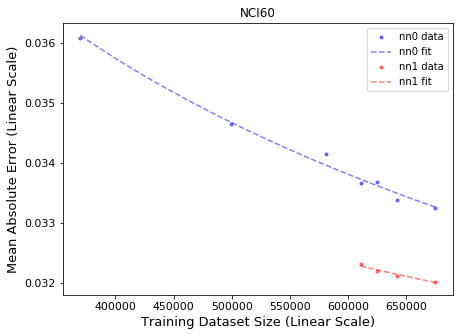

In [194]:
# Reset axes
ax = None

# NN0
if nn0 is not None:
    name = 'nn0'
    color = 'b'
    aa = dfit_nn0
    
    xf = aa['tr_size'].values
    yf = aa['y'].values
    cc_nn0 = FitPwrLaw(xf=xf, yf=yf, w=aa['w'].values)
    xf_plot_nn0, yf_plot_nn0 = cc_nn0.calc_fit( x1=xf[0], x2=xf[-1] )
    
    ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color=color, label=f'{name} data')
    ax = lc_plots.plot_lc(x=xf_plot_nn0, y=yf_plot_nn0, ax=ax, **fit_args, color=color, label=f'{name} fit')

# NN1
if nn1 is not None:
    name = 'nn1'
    color = 'r'
    aa = dfit_nn1
    
    xf = aa['tr_size'].values
    yf = aa['y'].values
    cc_nn1 = FitPwrLaw(xf=xf, yf=yf, w=aa['w'].values)
    xf_plot, yf_plot = cc_nn1.calc_fit( x1=xf[0], x2=xf[-1] )
    
    ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color=color, label=f'{name} data')
    ax = lc_plots.plot_lc(x=xf_plot, y=yf_plot, ax=ax, **fit_args, color=color, label=f'{name} fit')

# LGB
if lgb is not None:
    name = 'lgb'
    color = 'g'
    aa = dfit_lgb
    
    xf = aa['tr_size'].values
    yf = aa['y'].values
    cc_lgb = FitPwrLaw(xf=xf, yf=yf, w=aa['w'].values)
    xf_plot, yf_plot = cc_lgb.calc_fit( x1=xf[0], x2=xf[-1] )
    
    ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color=color, label=f'{name} data')
    ax = lc_plots.plot_lc(x=xf_plot, y=yf_plot, ax=ax, **fit_args, color=color, label=f'{name} fit')

ax.set_title(f'{src}')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

In [195]:
display(cc_nn0.coefs)

,coef,est,se,t_val,p_val
0,a,0.173178,0.256574,0.674960,0.536705
1,b,-0.091545,0.672262,-0.136174,0.898262
2,c,-0.017419,0.382363,-0.045557,0.965847


In [196]:
display(cc_nn1.coefs)

,coef,est,se,t_val,p_val
0,a,45.476320,7665.897159,0.005932,0.996223
1,b,-0.699784,14.112215,-0.049587,0.968458
2,c,0.028216,0.079030,0.357032,0.781687


In [27]:
display(cc_lgb.coefs)

NameError: name 'cc_lgb' is not defined

In [29]:
aa = nn0
aa['std'] = aa['score']
aa['min'] = aa['score']
aa['max'] = aa['score']
aa = aa.groupby(['tr_size']).agg({'score': 'median', 'std': 'std', 'min': 'min', 'max': 'max'}).reset_index()
aa = aa.rename(columns={'score': 'MAE_median'})
aa['%'] = aa['std']/aa['MAE_median']
aa

,tr_size,MAE_median,std,min,max,%
0,2024,0.069722,0.002723,0.065396,0.081206,0.039062
1,3272,0.065355,0.001848,0.062163,0.070789,0.028271
2,5292,0.061462,0.001791,0.058772,0.067611,0.029143
3,8557,0.057698,0.001153,0.055799,0.060618,0.019977
4,13837,0.053507,0.001229,0.051794,0.056341,0.022969
5,22375,0.049501,0.000920,0.048131,0.052482,0.018595
6,36181,0.045684,0.000824,0.044645,0.047753,0.018035
7,58506,0.042179,0.000680,0.041254,0.044441,0.016125
8,94606,0.039301,0.000514,0.038421,0.040799,0.013067
9,152979,0.036845,0.000480,0.035725,0.038452,0.013023


In [30]:
aa = nn1
aa['std'] = aa['score']
aa['min'] = aa['score']
aa['max'] = aa['score']
aa = aa.groupby(['tr_size']).agg({'score': 'median', 'std': 'std', 'min': 'min', 'max': 'max'}).reset_index()
aa = aa.rename(columns={'score': 'MAE_median'})
aa['%'] = aa['std']/aa['MAE_median']
aa

,tr_size,MAE_median,std,min,max,%
0,2024,0.068909,0.001621,0.066100,0.072508,0.023530
1,3272,0.065155,0.001868,0.061429,0.068759,0.028666
2,5292,0.060490,0.001835,0.057981,0.065394,0.030340
3,8557,0.056388,0.001435,0.053898,0.060105,0.025452
4,13837,0.053040,0.001236,0.050975,0.058335,0.023305
5,22375,0.048285,0.000903,0.046632,0.050460,0.018711
6,36181,0.044225,0.000673,0.042604,0.046114,0.015227
7,58506,0.040692,0.000582,0.039737,0.042488,0.014309
8,94606,0.037458,0.000491,0.036692,0.039221,0.013098
9,152979,0.035074,0.000525,0.034105,0.036394,0.014975


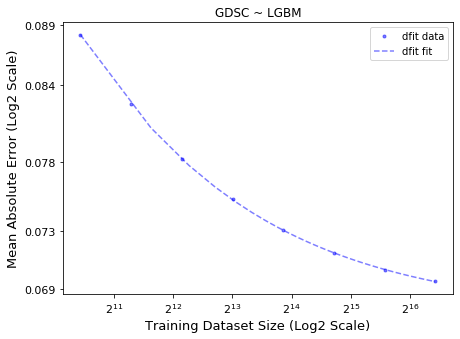

In [55]:
xf = dfit['tr_size'].values
# xe = dext['tr_size'].values
yf = dfit['y'].values
# ye = dext['y'].values

cc = FitPwrLaw(xf=dfit['tr_size'].values, yf=dfit['y'].values, w=dfit['w'].values)
xf_plot, yf_plot = cc.calc_fit( x1=xf[0], x2=xf[-1] )
# xe_plot, ye_plot = cc.calc_fit( x1=xe[0], x2=xe[-1] )

# Reset axes
ax = None

# Raw data
ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color='b', label='dfit data')
# ax = lc_plots.plot_lc(x=xe, y=ye, ax=ax, **pnts_args, color='r', label='dext data')

# Fits
ax = lc_plots.plot_lc(x=xf_plot, y=yf_plot, ax=ax, **fit_args, color='b', label='dfit fit')
# ax = lc_plots.plot_lc(x=xe_plot, y=ye_plot, ax=ax, **fit_args, color='r', label='dext fit')

ax.set_title(f'{src} ~ {model}')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

## Plot together